In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [6]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [13]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Donchian Channel Test

In [55]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("fast_mavg_log",                  fast_mavg_log),
            ("slow_mavg_log",                  slow_mavg_log),
            ("mavg_stepsize_log",              mavg_stepsize_log),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_saved_files",           use_saved_files),
            ("saved_file_end_date",       saved_file_end_date),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [18]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [20]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [22]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [24]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [26]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [71]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [112]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    # # Generate Trend Signal
    # df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
    #                                   slope_window=10, moving_avg_type=moving_avg_type,
    #                                   price_or_returns_calc=price_or_returns_calc)
    #             .rename(columns={
    #                 f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
    #                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # # Calculate Ribbon Slope and Z-Score
    # mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    # df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
    #     calc_ribbon_slope, 
    #     axis=1, 
    #     args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    # )

    # ## Calculate Trend Rank
    # ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    # ## slope near the origin takes into account even little information
    # df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    # Generate Donchian Channels
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    ## Donchian Channel Signal
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Weighted Sum of Rank Columns
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    # df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
    #                                                 donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])
    df_trend[final_weighted_additive_signal_col] = donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col]

    # Activation Scaled Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
        k = 1.0
    else:
        k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [114]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, 
                                                                use_donchian_exit_gate, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                                   rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Donchian Channel Breakout Parameter Optimization

In [117]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
start_date_os = pd.to_datetime('2022-01-01').date()
end_date_os = pd.to_datetime('2025-05-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
fast_mavg_log = 8
slow_mavg_log = 120
mavg_stepsize_log = 6
entry_rolling_donchian_window = 20
exit_rolling_donchian_window = 10
use_donchian_exit_gate = True
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-06-30'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.0
donchian_signal_weight = 1.0
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [119]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2016-01-01
end_date                      : 2022-12-31
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 35
slow_mavg                     : 60
mavg_stepsize                 : 6
fast_mavg_log                 : 8
slow_mavg_log                 : 120
mavg_stepsize_log             : 6
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.0

entry_rolling_donchian_window : 20
exit_rolling_donchian_window  : 10
use_donchian_exit_gate        : True
donchian_signal_weight        : 1.0

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
vol_of_vol_window_1           : 20
vol_of_vol_window_2           : 15
vol_of_vol_z_score_window     : 180

lower_r_sqr_limit         

In [148]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian\n",
## Stop Loss = 2.0 * ATR
ticker_list_test = ['BTC-USD']
df_donchian_only = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_test, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [149]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian

perf.calculate_risk_and_performance_metrics(df_donchian_only, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.44103016485908575,
 'annualized_sharpe_ratio': 0.9946487476818225,
 'calmar_ratio': 0.6880491285395494,
 'annualized_std_dev': 0.8010209276993215,
 'max_drawdown': -0.6409864449581018,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.26498422712933756,
 't_statistic': 2.9461613662126553,
 'p_value': 0.00324677021950213,
 'trade_count': 428.0}

In [124]:
df_donchian_only.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_20,BTC-USD_cash_shrink_factor,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_20,ETH-USD_cash_shrink_factor,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_20,SOL-USD_cash_shrink_factor,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_20,ADA-USD_cash_shrink_factor,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_20,AVAX-USD_cash_shrink_factor,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-21,3029.174214,0.000000,0.000000,0.654385,0.0,62204.02,0.0,NaN,0.879623,0.395402,0.00,0.000000,0.000000,66021.26,0.000000,0.000000,0.0,0.000000,False,66026.54,0.02

In [127]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]

<Axes: xlabel='date'>

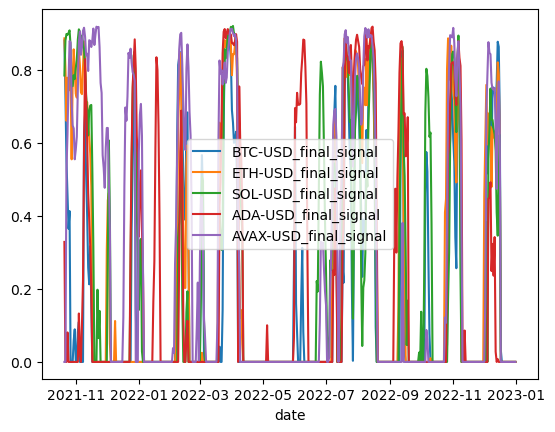

In [129]:
df_donchian_only[final_signal_cols].plot()

<Axes: xlabel='date'>

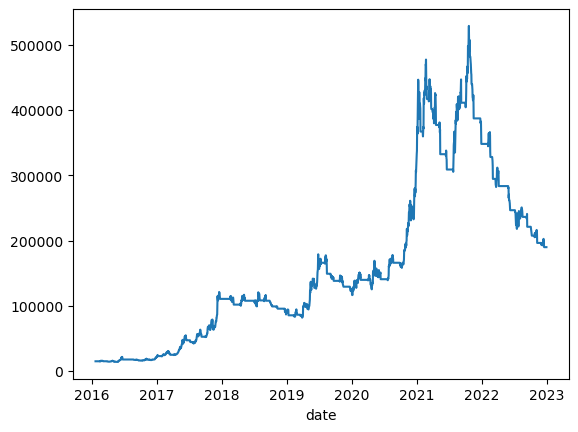

In [152]:
df_donchian_only['total_portfolio_value'].plot()

## Run-Walk Forward Analysis for Donchian Channels